In [1]:
import numpy as np                                     # linear algebra
import pandas as pd                                    # data processing, CSV file I/O (e.g. pd.read_csv)
import copy                                            #to copy list
from sklearn.model_selection import train_test_split   #to split dataset into train and test set
from sklearn.svm import SVC                            #to create svc instance
from sklearn.metrics import classification_report      #to create report for precision,recall,f1-score,accuracy
from sklearn import metrics                            #to get accuracy
from sklearn.model_selection import GridSearchCV       #to optimise the hyper-parameter
from sklearn.ensemble import RandomForestClassifier    #to create rf instance

In [2]:
df = pd.read_csv('Dataset1.csv')
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


In [3]:
#For SVC classifier
maxlen_seq = 10
input_seqs_svc, target_seqs_svc = df[['seq', 'sst8']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
#input_grams = seq2ngrams(input_seqs)
print("Total SVC Dataset :",len(input_seqs_svc))
print(input_seqs_svc[0:5])
print(" ")

#For random forest classifier
input_seqs_rf, target_seqs_rf = df[['seq', 'sst8']][(df.len > maxlen_seq) & (~df.has_nonstd_aa)].values.T
print("Total RF Dataset :",len(input_seqs_rf))
print(input_seqs_rf[0:5])

Total SVC Dataset : 3140
['EDL' 'KCK' 'KAK' 'KFK' 'KAK']
 
Total RF Dataset : 383193
['EPQYEEIPIYL' 'EPQYEEIPIYL' 'IKENLKDCGLF' 'GVQSLKRRRCF' 'SVLYTAVQPNE']


In [4]:
print(target_seqs_svc[0:5])
print(target_seqs_svc.size)

print(target_seqs_rf[0:5])
print(target_seqs_rf.size)

['CBC' 'CBC' 'CBC' 'CBC' 'CBC']
3140
['CCSSCCCCCCC' 'CCSSCCSCCCC' 'CCHHHHTTTCC' 'CCCEEEEEEEC' 'CCCBCCEECCC']
383193


In [5]:
for row in range(len(target_seqs_svc)):
    secondary_lenth_svc = len(target_seqs_svc[row])
    primary_lenth_svc = len(input_seqs_svc[row])
    
    if(secondary_lenth_svc != primary_lenth_svc):
        print("(",row,") Secondary_Structure ->", target_seqs_svc[row]," Primary_Structure -> ",input_seqs_svc[row])
    
    
for row in range(len(target_seqs_rf)):
    secondary_lenth_rf = len(target_seqs_rf[row])
    primary_lenth_rf = len(input_seqs_rf[row])
    
    if(secondary_lenth_rf != primary_lenth_rf):
        print("(",row,") Secondary_Structure ->", target_seqs_rf[row]," Primary_Structure -> ",input_seqs_rf[row])

In [6]:
secondary_count_svc = 0
primary_count_svc = 0
for row in range(len(target_seqs_svc)):
    secondary_lenth_svc = len(target_seqs_svc[row])
    primary_lenth_svc = len(input_seqs_svc[row])
    secondary_count_svc = secondary_count_svc + secondary_lenth_svc
    primary_count_svc = primary_count_svc + primary_lenth_svc
    if(secondary_lenth_svc != primary_lenth_svc):
        print("(",row,") Secondary_Structure ->", target_seqs_svc[row]," Primary_Structure -> ",input_seqs_svc[row])
        
print("count of secondary structure for SVC : ",secondary_count_svc)
print("count of primary structure for SVC : ",primary_count_svc)
print(" ")


secondary_count_rf = 0
primary_count_rf = 0
for row in range(len(target_seqs_rf)):
    secondary_lenth_rf = len(target_seqs_rf[row])
    primary_lenth_rf = len(input_seqs_rf[row])
    secondary_count_rf = secondary_count_rf + secondary_lenth_rf
    primary_count_rf = primary_count_rf + primary_lenth_rf
    if(secondary_lenth_rf != primary_lenth_rf):
        print("(",row,") Secondary_Structure ->", target_seqs_rf[row]," Primary_Structure -> ",input_seqs_rf[row])
        
print("count of secondary structure for RF : ",secondary_count_rf)
print("count of primary structure for RF : ",primary_count_rf)

count of secondary structure for SVC :  24906
count of primary structure for SVC :  24906
 
count of secondary structure for RF :  101297641
count of primary structure for RF :  101297641


In [7]:
def split(sequence): 
    return [char for char in sequence]

In [8]:
primary_split_svc = []
secondary_split_svc = []
svc_sz=0
for row in range(int(len(target_seqs_svc))):
    primary_split_svc.append(split(input_seqs_svc[row]))
    secondary_split_svc.append(split(target_seqs_svc[row]))
    svc_sz=max(svc_sz,len(input_seqs_svc[row]))

print("Number of Dataset for SVC :",len(secondary_split_svc))
print("Maximum length of Data for SVC :",svc_sz)
print(" ")


primary_split_rf = []
secondary_split_rf = []
rf_sz=0
for row in range(int(len(target_seqs_rf)/80)):
    primary_split_rf.append(split(input_seqs_rf[row]))
    secondary_split_rf.append(split(target_seqs_rf[row]))
    rf_sz=max(rf_sz,len(input_seqs_rf[row]))
              
print("Number of Dataset for RF :",len(secondary_split_rf))
print("Maximum length of Data for RF :",rf_sz)

Number of Dataset for SVC : 3140
Maximum length of Data for SVC : 10
 
Number of Dataset for RF : 4789
Maximum length of Data for RF : 20


In [9]:
def orthogonal_primary(arg):
    switch = {
        'A' : np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),  # 20 amino acids
        'C' : np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'E' : np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'D' : np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'G' : np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'F' : np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'I' : np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'H' : np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]),
        'K' : np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]),
        'M' : np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]),
        'L' : np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]),
        'N' : np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]),
        'Q' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]),
        'P' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]),
        'S' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]),
        'R' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]),
        'T' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]),
        'W' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]),
        'V' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]),
        'Y' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])
    }
    
    return switch.get(arg)

def orthogonal_secondary(arg):
    switch = {
        'H' : 0,                    # H= α-helix
        'C' : 1,                    # C= Loops and irregular elements
        'E' : 2,                    # E= β-strand
        'B' : 3,                    # B= β-bridge
        'G' : 4,                    # G= 3-helix
        'I' : 5,                    # I= π-helix
        'T' : 6,                    # T= Turn
        'S' : 7                     # S= Bend
    }
    
    return switch.get(arg)

In [10]:
for row in range(len(primary_split_svc)):
    sequence = primary_split_svc[row]
    for col in range(len(sequence)):
        sequence[col] = orthogonal_primary(sequence[col])
        
for row in range(len(primary_split_rf)):
    sequence = primary_split_rf[row]
    for col in range(len(sequence)):
        sequence[col] = orthogonal_primary(sequence[col])

In [11]:
for row in range(len(secondary_split_svc)):  
    sequenceS = secondary_split_svc[row]
    for col in range(len(sequenceS)):
        sequenceS[col] = orthogonal_secondary(sequenceS[col])
        
        
for row in range(len(secondary_split_rf)):  
    sequenceS = secondary_split_rf[row]
    for col in range(len(sequenceS)):
        sequenceS[col] = orthogonal_secondary(sequenceS[col])

In [12]:
print(primary_split_svc[0:5])
print(secondary_split_svc[0:5])

[[array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0,

In [13]:
print(primary_split_rf[0:5])
print(secondary_split_rf[0:5])

[[array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
def getMapping(arg):
    for i in range (len(arg)):
        if arg[i]==1:
            return i;

In [15]:
def conformationParameter(primary, secondary):
    pr=[]
    for i in range(len(primary)):
        pr.append(getMapping(primary[i]))
        
    conf=np.zeros((8,20), dtype=int)
    for i in range(8):
        for j in range(20):
            countpair=0
            countprimary=0
            for k in range(len(pr)):
                if pr[k]==j:
                    countprimary=countprimary+1
                    if secondary[k]==i:
                        countpair=countpair+1
                if countpair!=0:
                    conf[i][j]=countpair/countprimary
    return conf

In [16]:
conf_svc=np.zeros((len(primary_split_svc),8,20))

for i in range(len(primary_split_svc)):
    conf_svc[i]=conformationParameter(primary_split_svc[i],secondary_split_svc[i])
        
print(len(conf_svc))
print(len(secondary_split_svc))
print(conf_svc[0:3])

3140
3140
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0

In [17]:
conf_rf=np.zeros((len(primary_split_rf),8,20))

for i in range(len(primary_split_rf)):
    conf_rf[i]=conformationParameter(primary_split_rf[i],secondary_split_rf[i])
        
print(len(conf_rf))
print(len(secondary_split_rf))
print(conf_rf[0:3])

4789
4789
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0

In [18]:
def graph_sum2(seq1,seq2):
    result = [None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]
    return result

def graph_sum3(seq1,seq2,seq3):
    result = [None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]+seq3[col]
    return result

In [19]:
#Building the graph neural netword for svc
graph_input_svc = copy.deepcopy(primary_split_svc)
for row in range(len(primary_split_svc)):
    sequence = primary_split_svc[row]
    graph_input_svc[row][0]=graph_sum2(sequence[0],sequence[1])
    graph_input_svc[row][len(sequence)-1]=graph_sum2(sequence[len(sequence)-1],sequence[len(sequence)-2])
    for col in range(1,len(sequence)-1):
        graph_input_svc[row][col] = graph_sum3(sequence[col-1],sequence[col],sequence[col+1])
        
graph_input_svc[0:5]

[[[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

In [20]:
#Building the graph neural netword for RF
graph_input_rf = copy.deepcopy(primary_split_rf)
for row in range(len(primary_split_rf)):
    sequence = primary_split_rf[row]
    graph_input_rf[row][0]=graph_sum2(sequence[0],sequence[1])
    graph_input_rf[row][len(sequence)-1]=graph_sum2(sequence[len(sequence)-1],sequence[len(sequence)-2])
    for col in range(1,len(sequence)-1):
        graph_input_rf[row][col] = graph_sum3(sequence[col-1],sequence[col],sequence[col+1])
        
graph_input_rf[0:5]

[[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]],
 [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:
def targetY(data_list):
    Y = []
    for i in range(len(data_list)):
        for j  in range(len(data_list[i])):
            Y.append(data_list[i][j])
    return Y

In [22]:
def window_padding_data(size, sequence):
    num = int(size/2)

    zeros = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    for i in range(len(sequence)):
        temp=[]
        for j in range(num):
            sequence[i].append(zeros)
            sequence[i].insert(0, zeros)

    X = []
    temp = []

    for k in range(len(sequence)):
        #print(sequence[k])
        for l in range(len(sequence[k])-(size-1)):
            temp = sequence[k][l:l+size]
           # print(temp)
            X.append(temp)
            temp = []

    return X

In [23]:
for i in range(len(graph_input_svc)):
    for j in range(len(conf_svc[i])):
        graph_input_svc[i].append(conf_svc[i][j])
        secondary_split_svc[i].append(0)

graph_input_svc[0:3]

[[[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.])],
 [[0, 1

In [24]:
for i in range(len(graph_input_rf)):
    for j in range(len(conf_rf[i])):
        graph_input_rf[i].append(conf_rf[i][j])
        secondary_split_rf[i].append(0)

print(graph_input_rf[0:2])
print(secondary_split_rf[0:2])


[[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0

In [25]:
y_label_svc = targetY(secondary_split_svc)
y_label_rf = targetY(secondary_split_rf)

In [26]:
print(len(y_label_svc))
print(y_label_svc[0:5])
print(len(y_label_rf))
print(y_label_rf[0:5])

50026
[1, 3, 1, 0, 0]
106435
[1, 1, 7, 7, 1]


In [27]:
X_svc = window_padding_data(21,graph_input_svc)
print(len(X_svc))
X_svc[0:5]

50026


[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.])

In [28]:
print(len(graph_input_rf))
X_rf = window_padding_data(21,graph_input_rf)
print(len(X_rf))
X_rf[0:5]

4789
106435


[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0

In [29]:
for i in range(len(X_svc)):
    temp=[]
    for j in range(len(X_svc[i])):
        for k in range(len(X_svc[i][j])):
            temp.append(X_svc[i][j][k])
    X_svc[i]=temp
X_svc[0:5]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [30]:
for i in range(len(X_rf)):
    temp=[]
    for j in range(len(X_rf[i])):
        for k in range(len(X_rf[i][j])):
            temp.append(X_rf[i][j][k])
    X_rf[i]=temp
print(X_rf[0:5])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [31]:
print(len(X_rf))
print(X_rf[0:5])

106435
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0

In [32]:
np.set_printoptions(threshold=np.inf)
X_svc = np.asarray(X_svc)
y_label_svc = np.asarray(y_label_svc)
print(X_svc[0:2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 

In [33]:
X_rf = np.asarray(X_rf)
y_label_rf = np.asarray(y_label_rf)
# X_rf = X_rf.reshape(len(X_rf),11*20)
print(X_rf[0:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 

In [34]:
#split the dataset into train set and test set
x_train_svc, x_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_label_svc, test_size = 0.20,random_state=54)

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_label_rf, test_size = 0.20,random_state=54)

In [35]:
import time
start_time = time.time()
#predicting the smaller length dataset by svc
svc = SVC(kernel='rbf', gamma = 0.1, C=1.5)
svc.fit(x_train_svc, y_train_svc)
y_pred_svc = svc.predict(x_test_svc)

#predicting the larger length dataset by random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_rf, y_train_rf)
y_pred_rf=rf.predict(x_test_rf)

print("--- %s seconds ---" % (time.time() - start_time))
print(" ")

#calculating the accuracy by ensembling the result
y_test=[]
for i in range(len(y_test_svc)):
    y_test.append(y_test_svc[i])
for i in range(len(y_test_rf)):
    y_test.append(y_test_rf[i])
y_test=np.array(y_test)
    
y_pred = []
for i in range(len(y_pred_svc)):
    y_pred.append(y_pred_svc[i])
for i in range(len(y_pred_rf)):
    y_pred.append(y_pred_rf[i])
y_pred=np.array(y_pred)
    
y_true = []
for i in range(len(y_test_svc)):
    y_true.append(y_test_svc[i])
for i in range(len(y_test_rf)):
    y_true.append(y_test_rf[i])
y_true=np.array(y_true)


print("Accuracy = ",metrics.accuracy_score(y_test, y_pred)*100)
print(classification_report(y_true,y_pred)) 

--- 2167.091812610626 seconds ---
 
Accuracy =  92.6213530182469
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15386
           1       0.87      0.97      0.92     11121
           2       0.93      0.80      0.86      1877
           3       0.87      0.64      0.74       414
           4       0.85      0.65      0.74       362
           6       0.78      0.54      0.64       941
           7       0.79      0.56      0.65      1192

    accuracy                           0.93     31293
   macro avg       0.87      0.73      0.79     31293
weighted avg       0.93      0.93      0.92     31293



In [36]:
EPSILON = 1e-10
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Relative Absolute Error(RAE):', np.sum(np.abs(y_test - y_pred)) / (np.sum(np.abs(y_test - np.mean(y_test))) + EPSILON))
print('Root Relative Squared Error(RRSE):', np.sqrt(np.sum(np.square(y_test - y_pred)) / np.sum(np.square(y_test - np.mean(y_test)))))

Mean Absolute Error(MAE): 0.24401623366248043
Mean Squared Error(MSE): 1.176301409260857
Root Mean Squared Error(RMSE): 1.0845742986355784
Relative Absolute Error(RAE): 0.24461925239212393
Root Relative Squared Error(RRSE): 0.6445210615301358


In [37]:
import matplotlib.pyplot as plt
import seaborn as sn

In [38]:
pd.crosstab(y_pred,y_test)

col_0,0,1,2,3,4,6,7
row_0,,,,,,,
0,15048,120,7,3,13,65,26
1,289,10759,344,101,90,291,437
2,0,63,1496,36,1,7,10
3,0,19,18,267,0,2,1
4,11,7,2,0,237,18,5
6,30,46,2,2,17,511,47
7,8,107,8,5,4,47,666


In [39]:
confusion=pd.crosstab(y_pred,y_test)

<Axes: xlabel='Actual Class', ylabel='Predicted Class'>

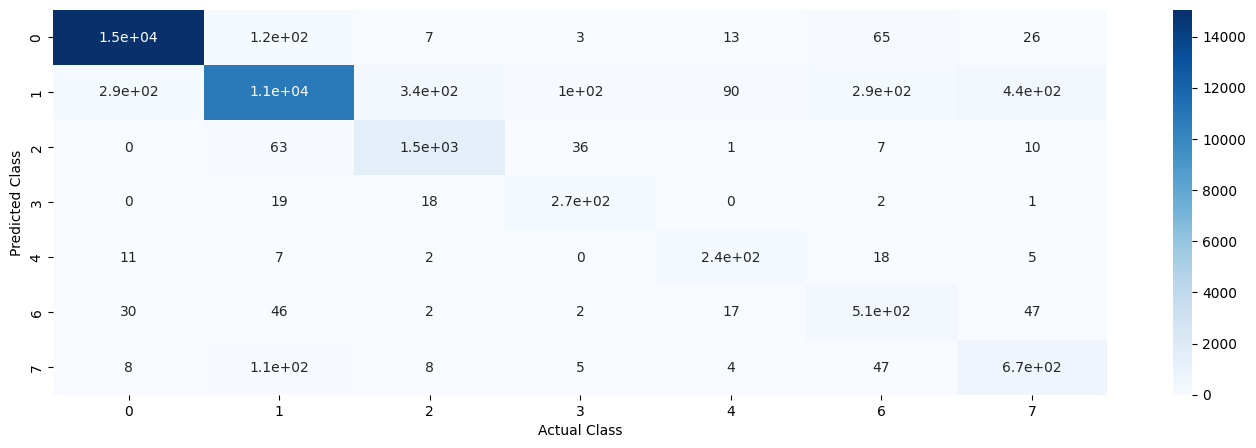

In [45]:
fig=plt.figure(figsize=(17,5))
s=sn.heatmap(confusion,annot=True,cmap='Blues')
s.set(xlabel='Actual Class', ylabel='Predicted Class')
s

In [242]:
inputvalue = ['ERHKILHRLLQEG']
actualoutput = ['CCCHHHHHHTTCC']

sz=len(inputvalue)
input_split = []
output_split = []
input_split.append(split(inputvalue[0]))
output_split.append(split(actualoutput[0]))
print(input_split)
print(output_split)

[['E', 'R', 'H', 'K', 'I', 'L', 'H', 'R', 'L', 'L', 'Q', 'E', 'G']]
[['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'T', 'T', 'C', 'C']]


In [243]:
chain = input_split[0]
for col in range(len(chain)):
    chain[col] = orthogonal_primary(chain[col])
    

chainS = output_split[0]
for col in range(len(chainS)):
    chainS[col] = orthogonal_secondary(chainS[col])

print(input_split)
print(output_split)

[[array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]]
[[1, 1, 1, 0, 0, 0, 0, 0, 0, 6, 6, 1, 1]]


In [244]:
conf=np.zeros((8,20))

conf=conformationParameter(input_split[0],output_split[0])
        
print(conf)

[[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [245]:
g_input = copy.deepcopy(input_split)
for row in range(len(input_split)):
    chain = input_split[row]
    g_input[row][0]=graph_sum2(chain[0],chain[1])
    g_input[row][len(chain)-1]=graph_sum2(chain[len(chain)-1],chain[len(chain)-2])
    for col in range(1,len(chain)-1):
        g_input[row][col] = graph_sum3(chain[col-1],chain[col],chain[col+1])
print(g_input)

[[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]


In [246]:
for j in range(len(conf)):
    g_input[0].append(conf[j])
    output_split[0].append(0)

print(g_input)
print(output_split)

[[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [247]:
actualY = targetY(output_split)
print(actualY)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 6, 6, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [248]:
input_X = window_padding_data(17,g_input)
#print(input_X)
temp=[]
for i in range(len(input_X)):
    temp=[]
    for j in range(len(input_X[i])):
        for k in range(len(input_X[i][j])):
            temp.append(input_X[i][j][k])
    input_X[i]=temp

print(input_X)
input_X = np.array(input_X)
actualY = np.array(actualY)
# print(input_X)
# print(actualY)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,

In [249]:
pred_output=[]
if sz<=10:
    pred_output=svc.predict(input_X)
else:
    pred_output=rf.predict(input_X)

In [250]:
print("Actual     :",actualY)
print("Prediction :",pred_output)

Actual     : [1 1 1 0 0 0 0 0 0 6 6 1 1 0 0 0 0 0 0 0 0]
Prediction : [1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
